In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### Read Benchmark Data

In [228]:
benchmark_results_path = "../results/"
data = []
for root, dirs, files in os.walk(benchmark_results_path):
    for file in files:
        if file.endswith(".csv"):
            df_ = pd.read_csv(os.path.join(root, file))
            data.append(df_)

df = pd.concat(data)
human_and_random_scores = pd.read_csv("human_and_random_scores.csv")

In [229]:
df.head()

,model_name,env_id,prompt_chain,temperature,context_length,episode_reward,episode_length
0,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,0,285.0,721
1,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,0,285.0,718
2,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,0,285.0,724
0,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,2,240.0,771
1,Qwen/Qwen2.5-0.5B-Instruct,SpaceInvaders,simple,0.01,2,180.0,599


In [230]:
human_and_random_scores.head()

,model_name,env_id,prompt_chain,temperature,context_length,episode_reward,episode_length
0,random,Alien,NaN,NaN,NaN,227.8,0
1,human,Alien,NaN,NaN,NaN,7127.7,0
2,random,Amidar,NaN,NaN,NaN,5.8,0
3,human,Amidar,NaN,NaN,NaN,1719.5,0
4,random,Assault,NaN,NaN,NaN,222.4,0


### Aggregate Results for each Benchmark run

In [231]:
df['mean_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('mean')
df['std_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_reward'].transform('std')
df['mean_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('mean')
df['std_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length'])['episode_length'].transform('std')

Separate data from random agent (baseline) and LLM agents

In [232]:
df = df[df["model_name"] != "random"]

### Plot

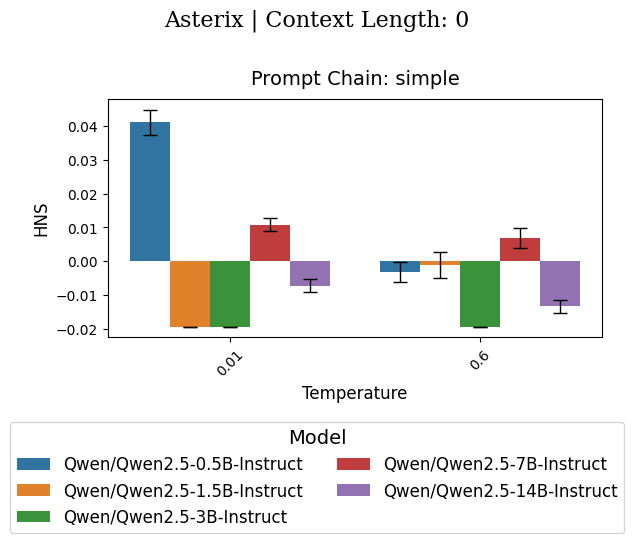

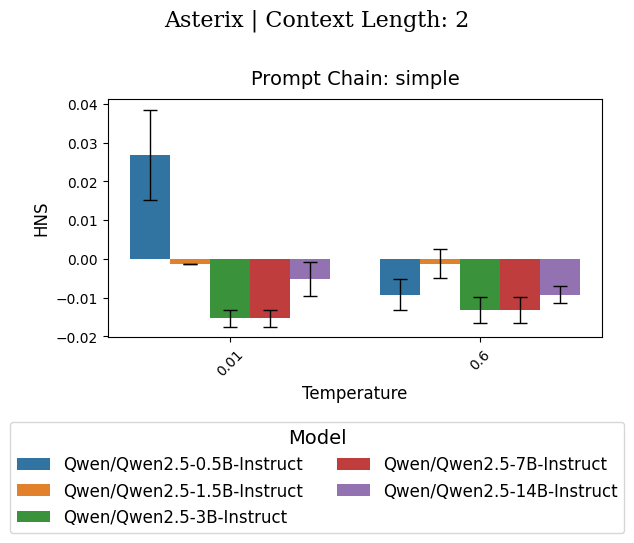

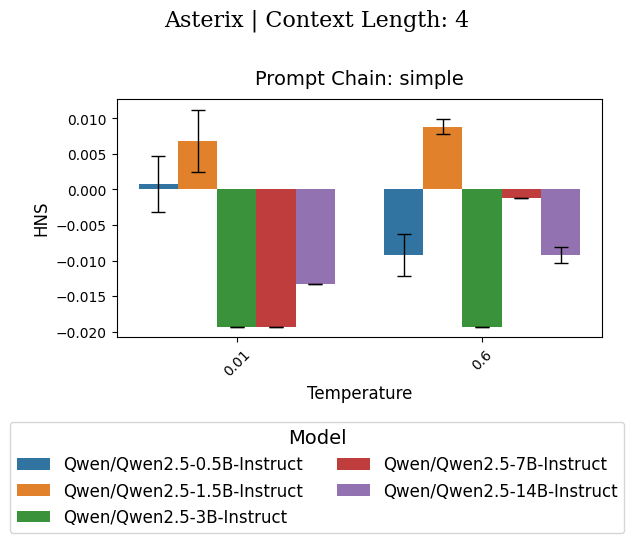

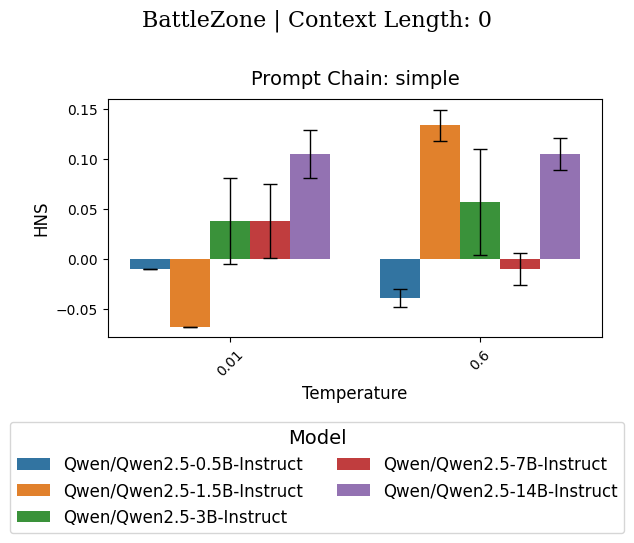

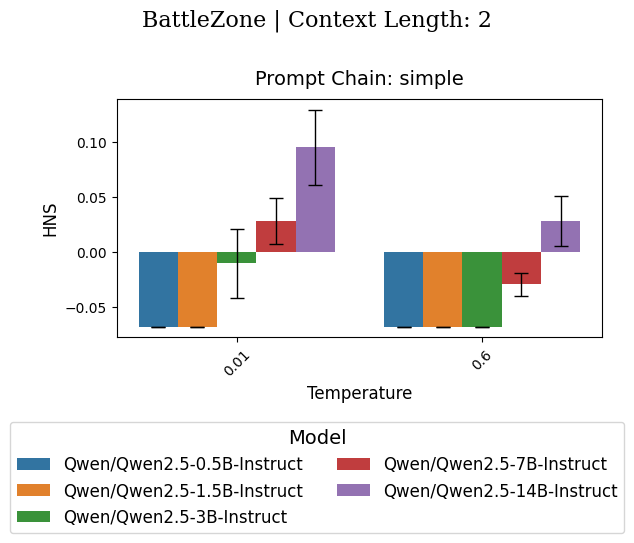

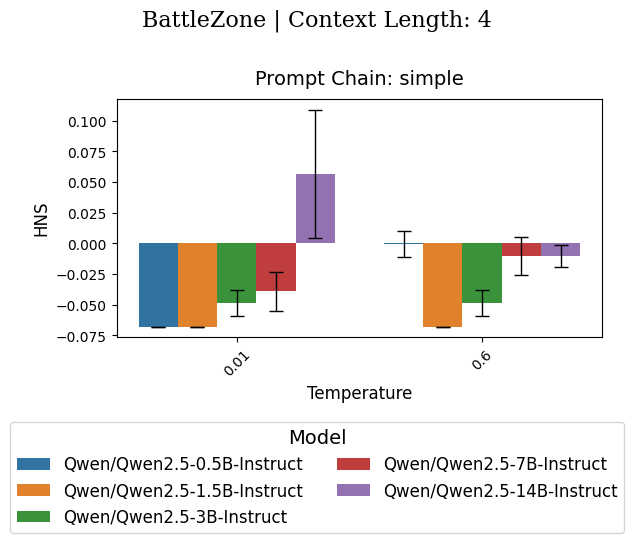

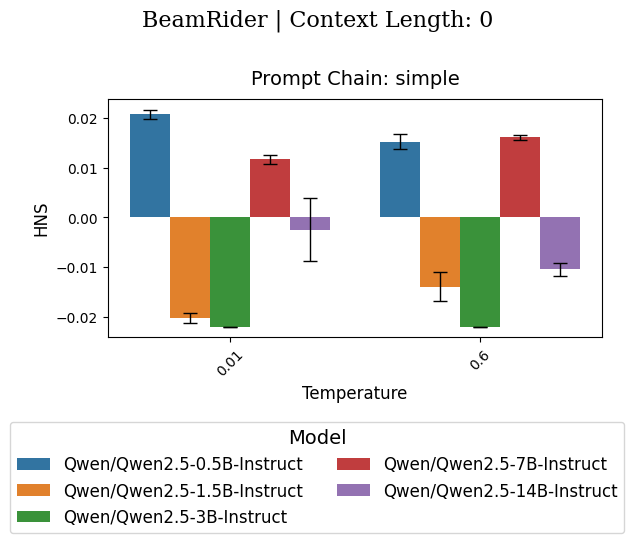

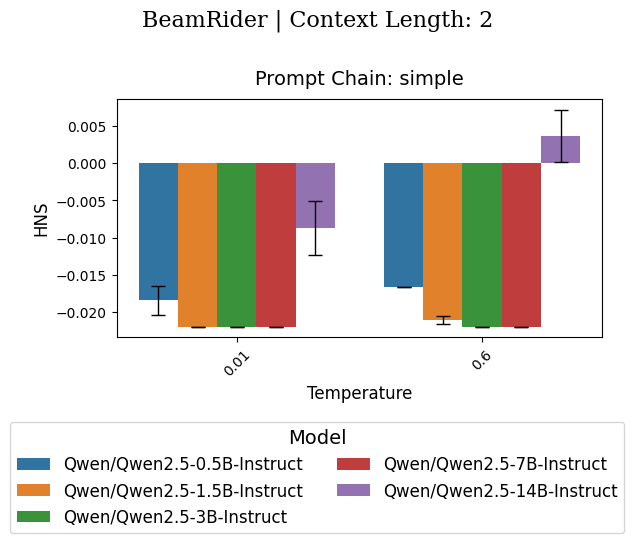

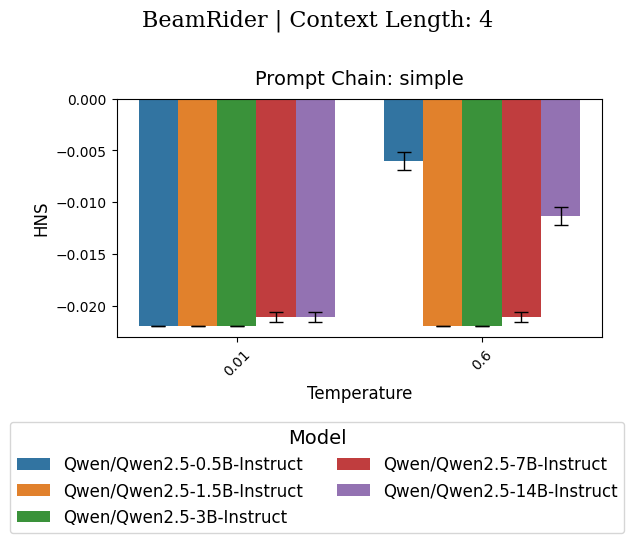

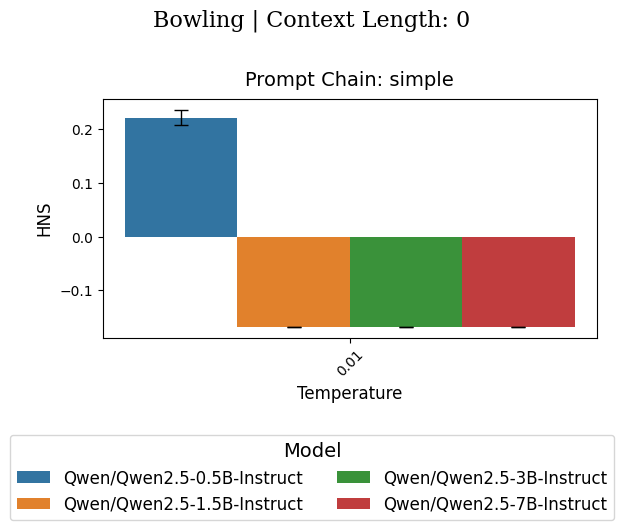

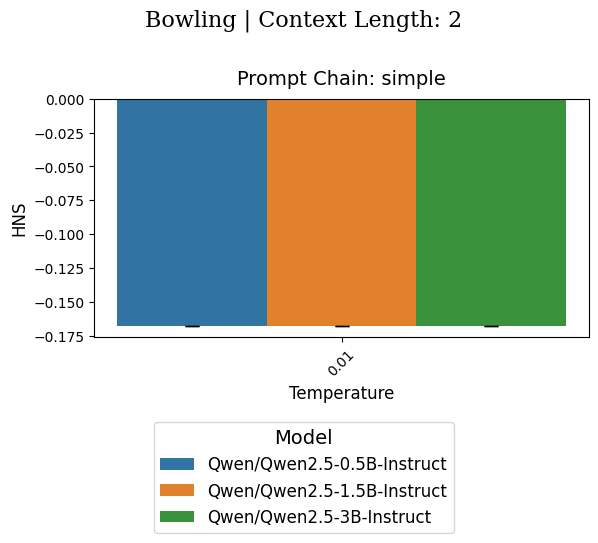

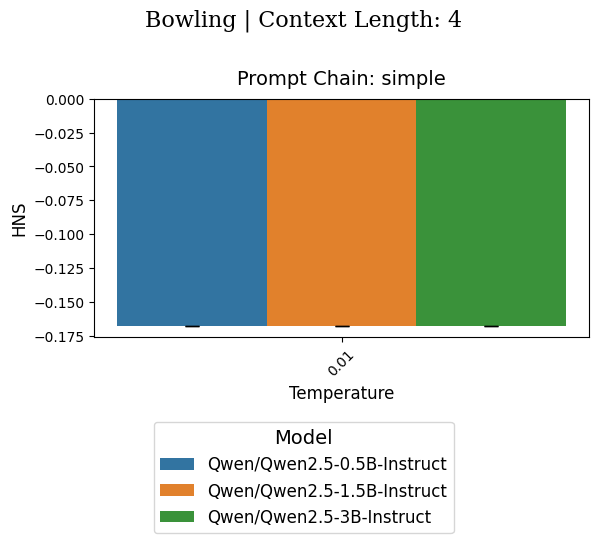

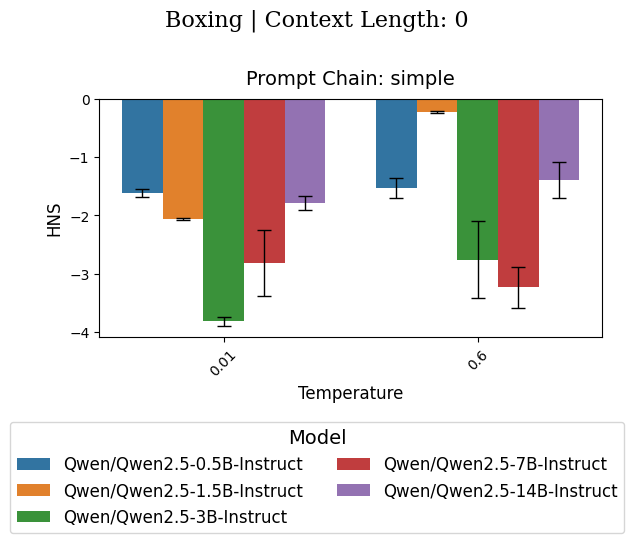

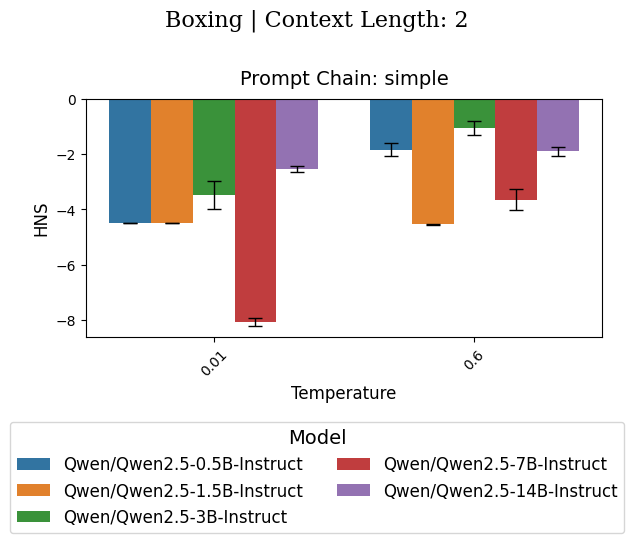

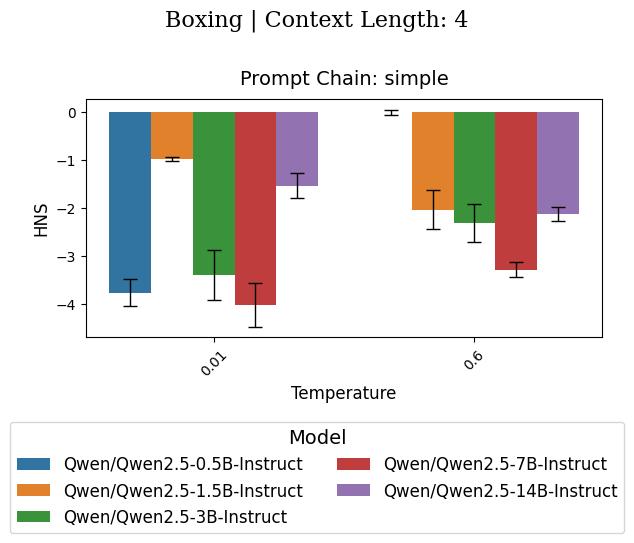

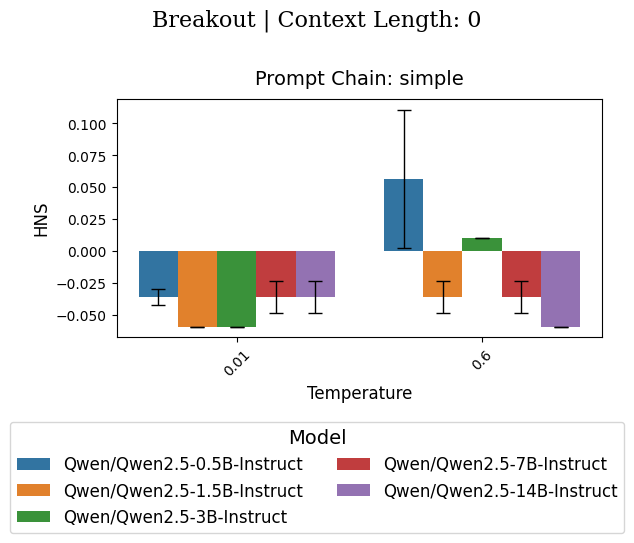

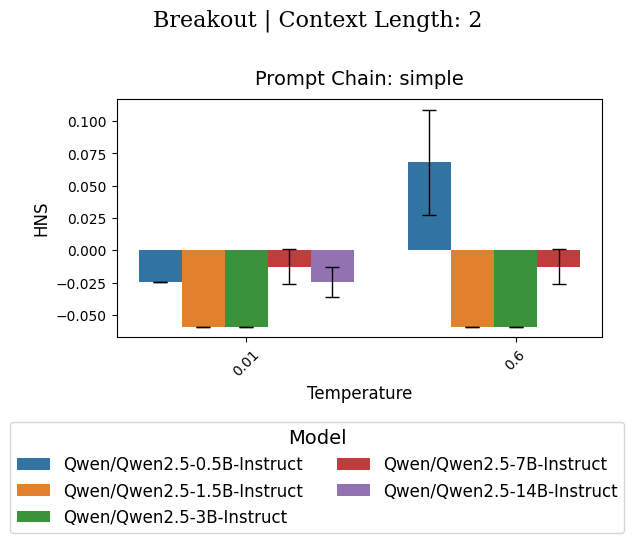

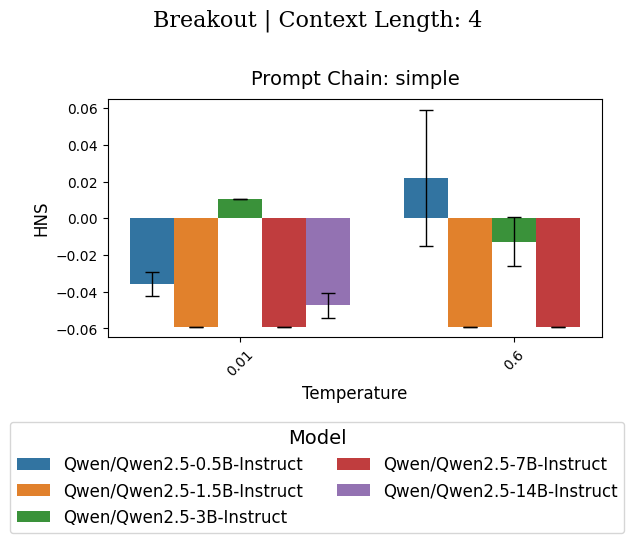

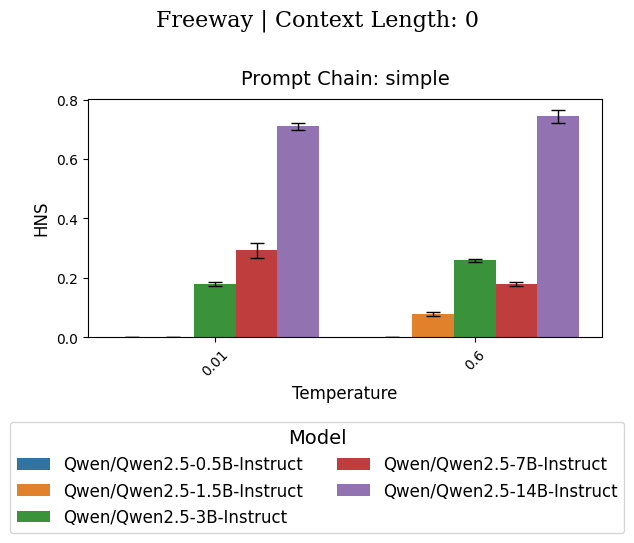

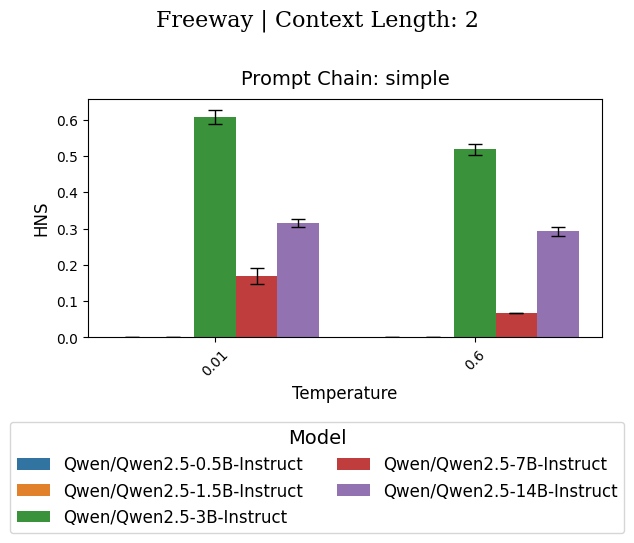

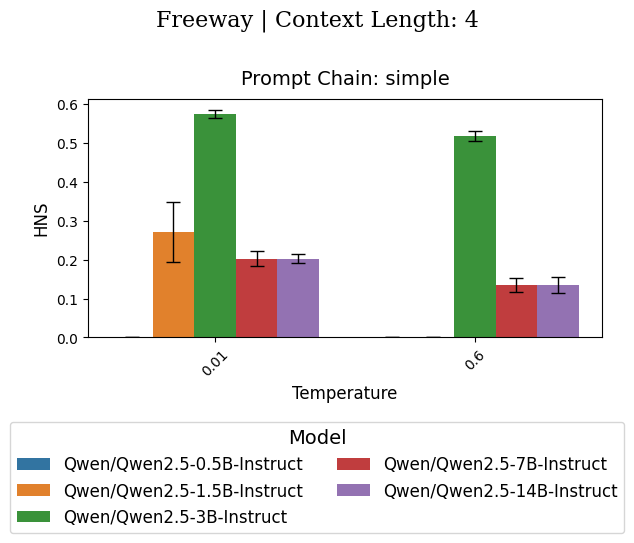

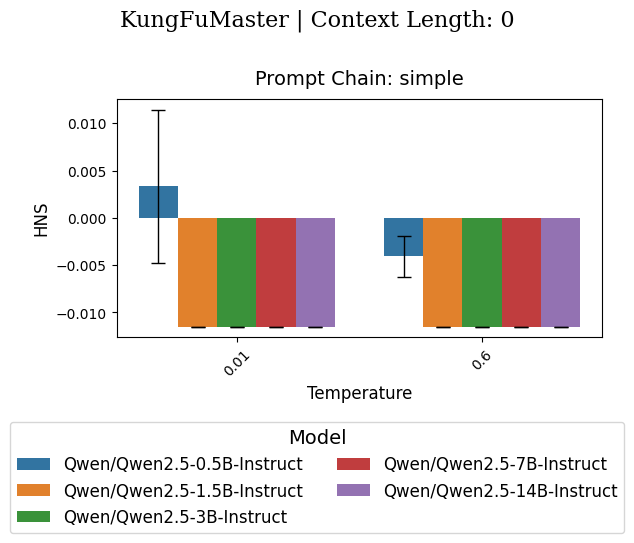

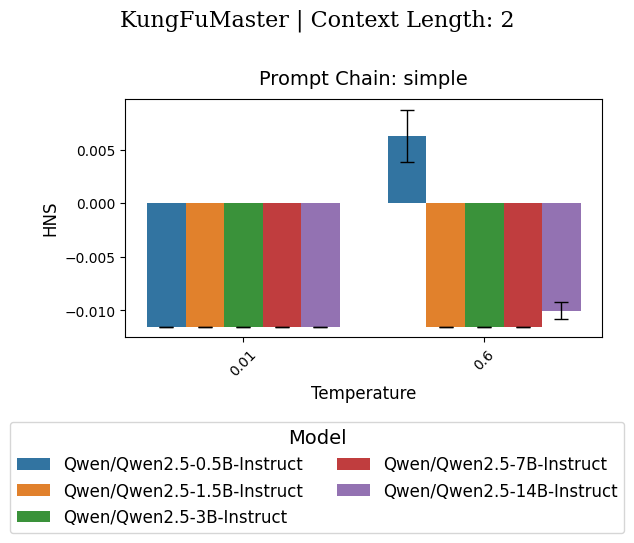

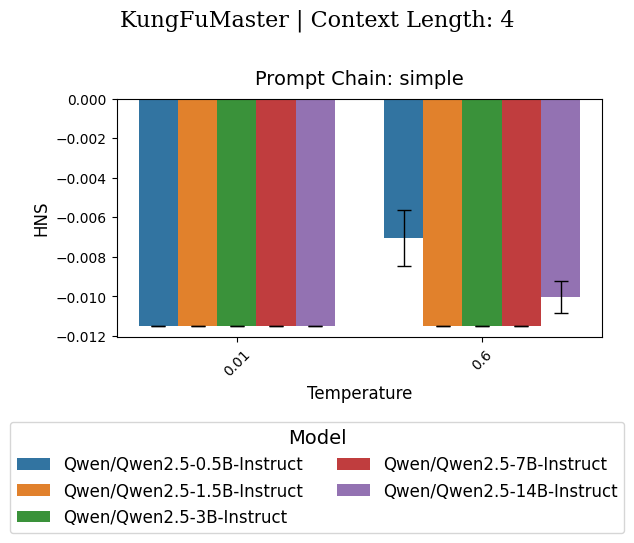

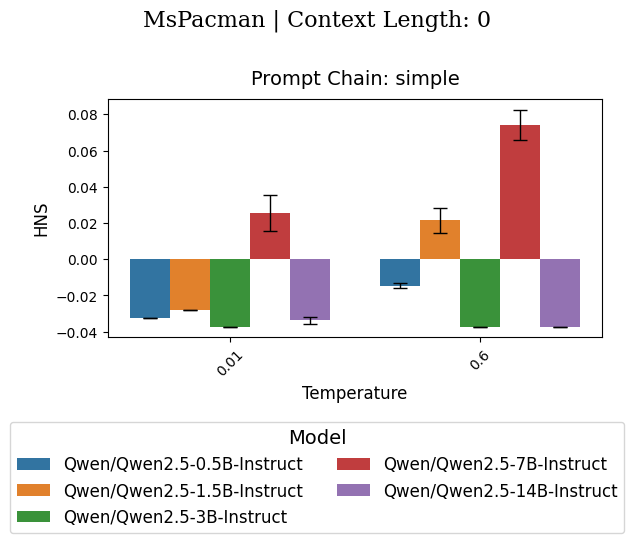

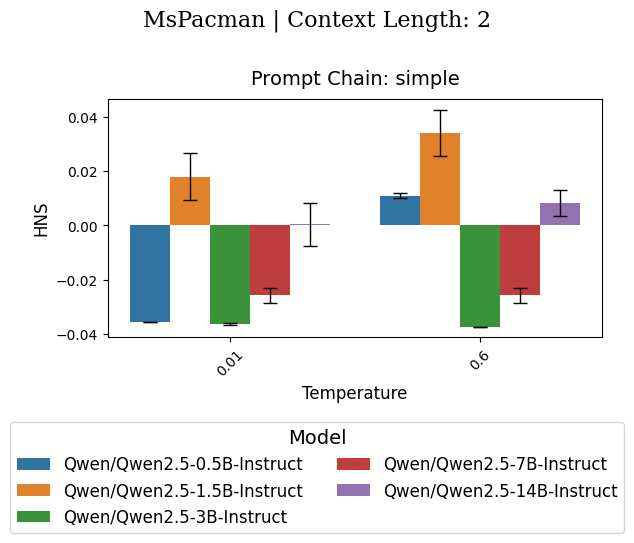

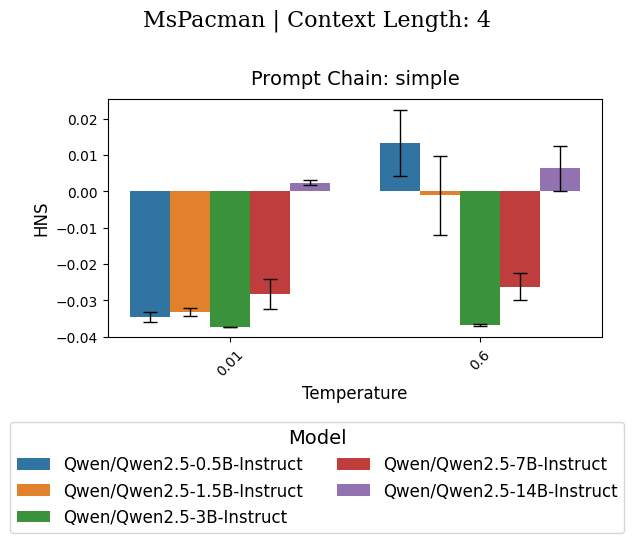

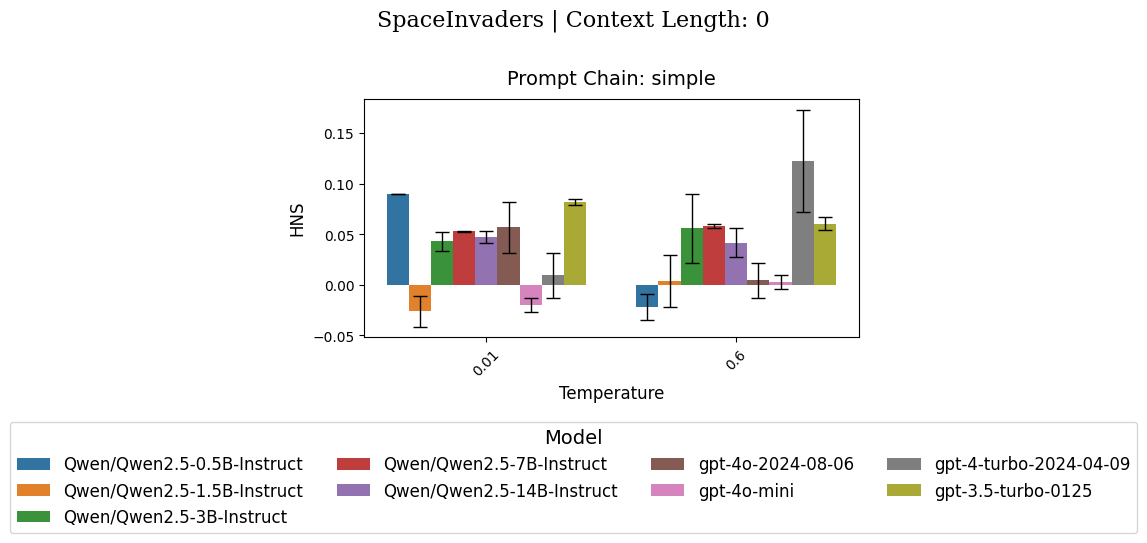

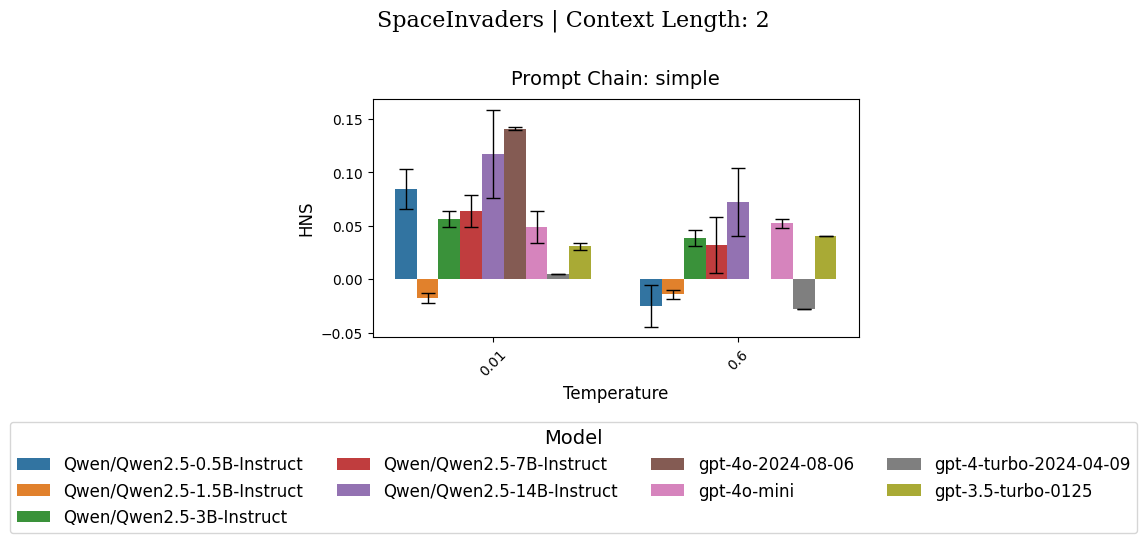

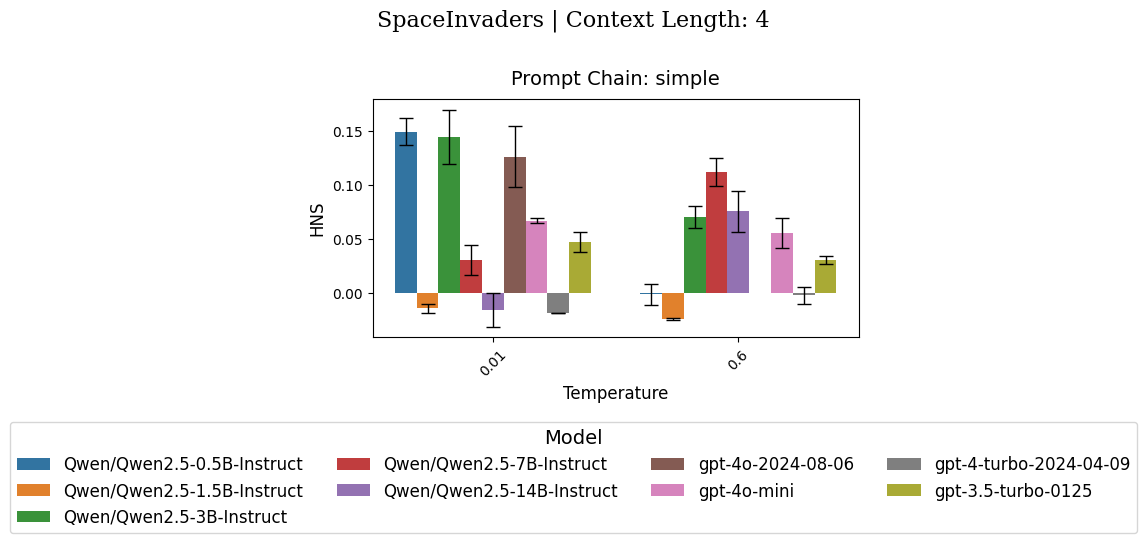

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 0. Precompute HNS ---------------------------------------------------

baselines = human_and_random_scores.pivot(
    index='env_id',
    columns='model_name',
    values='episode_reward'
).rename(columns={'human':'R_human','random':'R_random'}).reset_index()

df = df.merge(baselines, on='env_id', how='left')
df['HNS'] = (df['mean_reward'] - df['R_random']) / (df['R_human'] - df['R_random'])

# --- 1. Setup -------------------------------------------------------------

# --- Setup ---
palette         = dict(zip(df['model_name'].unique(), sns.color_palette("tab10", df['model_name'].nunique())))
prompt_chains   = sorted(df['prompt_chain'].unique())
temperatures    = sorted(df['temperature'].unique())
context_lengths = sorted(df['context_length'].unique())
env_order       = sorted(df['env_id'].unique())

df['env_id']       = pd.Categorical(df['env_id'], categories=env_order, ordered=True)
df['prompt_chain'] = pd.Categorical(df['prompt_chain'], categories=prompt_chains, ordered=True)

# --- Plot per-(env, context) ---
for env in env_order:
    for ctx in context_lengths:
        sub = df[(df['env_id']==env) & (df['context_length']==ctx)]
        if sub.empty:
            continue

        n_chains = len(prompt_chains)
        fig, axes = plt.subplots(
            n_chains, 1,
            figsize=(6, 4 * n_chains),
            sharey=True,
            sharex=True
        )
        if n_chains == 1:
            axes = [axes]

        for ax, prompt_chain in zip(axes, prompt_chains):
            data = sub[sub['prompt_chain'] == prompt_chain]

            # ✅ Drop duplicates to keep only one row per config
            data = data.drop_duplicates(
                subset=['model_name', 'env_id', 'prompt_chain', 'temperature', 'context_length']
            )

            if data.empty:
                ax.set_visible(False)
                continue

            sns.barplot(
                data=data,
                x='temperature', y='HNS',
                hue='model_name',
                palette=palette,
                ci=None,  # manual error bars
                dodge=True,
                width=0.8,
                ax=ax
            )

            # Manual error bars (clean, index-aligned)
            for i, bar in enumerate(ax.patches):
                # Compute the center of the bar
                center = bar.get_x() + bar.get_width() / 2
                height = bar.get_height()

                # Map bar to data row (i-th row in grouped barplot)
                if i >= len(data):
                    continue
                row = data.iloc[i]

                # Convert std to HNS units
                std_norm = float(row['std_reward'] / (row['R_human'] - row['R_random']))

                ax.errorbar(
                    center,
                    height,
                    yerr=std_norm / np.sqrt(len(data)),
                    fmt='none',
                    ecolor='black',
                    capsize=5,
                    capthick=1,
                    elinewidth=1,
                    zorder=10
                )

            ax.set_ylabel("HNS", fontsize=12)
            ax.set_xlabel("Temperature", fontsize=12)
            ax.set_xticklabels(temperatures, rotation=45)
            ax.set_title(f"Prompt Chain: {prompt_chain}", pad=10, fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=10)

            # Remove per-plot legend
            ax.legend_.remove()

        # Shared legend
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(
            handles, labels,
            title="Model",
            loc='center',
            bbox_to_anchor=(0.5, -0.15 / n_chains),
            ncol=len(labels) // 2,
            frameon=True,
            fontsize=12,
            title_fontsize=14,
            borderaxespad=1
        )

        fig.suptitle(f"{env} | Context Length: {ctx}", fontsize=16, y=1.02, fontfamily='serif')
        plt.tight_layout()
        plt.show()